In [2]:
# Enable IPython autoreload for modules
%load_ext autoreload
%autoreload 2

import pandas as pd 
# Load configuration
data_dir = None # To silence Pylance; data_dir is defined by config.py
%run ../../../config.py



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/max/proj/WirelessIncome
Data directory: /Users/max/proj/WirelessIncome/data


In [3]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [4]:
from pathlib import Path
from subprocess import run

# URL for 2019 tract cartographic boundary file
tract_carto = "https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_tract_500k.zip"

tracts_fn = Path(tract_carto).name
tracts_path = Path(data_dir) / tracts_fn

if not tracts_path.exists():
    print(f"Downloading {tracts_fn}...")
    result = run(["wget", "-P", data_dir, tract_carto], capture_output=True, text=True)
    if result.returncode == 0:
        print(f"Downloaded to {tracts_path}")
    else:
        print(f"Error downloading: {result.stderr}")
else:
    print(f"{tracts_fn} already exists at {tracts_path}")

# Load the tract shapefile

tracts_gdf = gpd.read_file(tracts_path)

tracts_gdf.head()

Downloaded to /Users/max/proj/WirelessIncome/data/cb_2019_us_tract_500k.zip
Downloaded to /Users/max/proj/WirelessIncome/data/cb_2019_us_tract_500k.zip


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,34,005,702808,1400000US34005702808,34005702808,7028.08,CT,1510553,0,"POLYGON ((-74.90801 40.0325, -74.90496 40.0364..."
1,39,153,504200,1400000US39153504200,39153504200,5042,CT,808151,0,"POLYGON ((-81.51807 41.05957, -81.51805 41.062..."
2,36,071,000502,1400000US36071000502,36071000502,5.02,CT,967431,969216,"POLYGON ((-74.02226 41.49281, -74.0218 41.4967..."
3,06,013,370000,1400000US06013370000,06013370000,3700,CT,999356,0,"POLYGON ((-122.32697 37.93502, -122.3261 37.93..."
4,48,113,019204,1400000US48113019204,48113019204,192.04,CT,2851229,9966,"POLYGON ((-96.76902 32.94655, -96.76899 32.950..."


In [5]:
# Get Census data - 2019 ACS 5-Year median household income by tract
# B19013_001E is median household income
# We'll get all tracts in all states

print("Fetching ACS 2019 5-Year median household income data by tract...")

# Get state FIPS codes first
states_url = "https://api.census.gov/data/2019/acs/acs5?get=NAME&for=state:*"
states_response = requests.get(states_url)
states_data = states_response.json()
state_fips = set([row[1] for row in states_data[1:]])  # Skip header

print(f"Found {len(state_fips)} states/territories")

# Fetch median income for all tracts in each state
all_tracts = []

for i, state_fips_code in enumerate(state_fips):  # Get all states
    try:
        url = f"https://api.census.gov/data/2019/acs/acs5?get=NAME,B19013_001E&for=tract:*&in=state:{state_fips_code}"
        response = requests.get(url)
        data = response.json()
        
        # Convert to dataframe
        df = pd.DataFrame(data[1:], columns=data[0])
        all_tracts.append(df)
        print(f"  State {state_fips_code}: {len(df)} tracts")
    except Exception as e:
        print(f"  Error fetching state {state_fips_code}: {e}")

# Combine all data
income_df = pd.concat(all_tracts, ignore_index=True)

# Clean up the data
income_df['median_income'] = pd.to_numeric(income_df['B19013_001E'], errors='coerce')
income_df['GEOID'] = income_df['state'] + income_df['county'] + income_df['tract']

income_df.head()


Fetching ACS 2019 5-Year median household income data by tract...
Found 52 states/territories
Found 52 states/territories
  State 41: 834 tracts
  State 41: 834 tracts
  State 05: 686 tracts
  State 05: 686 tracts
  State 10: 218 tracts
  State 10: 218 tracts
  State 15: 351 tracts
  State 15: 351 tracts
  State 19: 825 tracts
  State 19: 825 tracts
  State 36: 4918 tracts
  State 36: 4918 tracts
  State 32: 687 tracts
  State 32: 687 tracts
  State 53: 1458 tracts
  State 53: 1458 tracts
  State 27: 1338 tracts
  State 27: 1338 tracts
  State 34: 2010 tracts
  State 34: 2010 tracts
  State 28: 664 tracts
  State 28: 664 tracts
  State 17: 3123 tracts
  State 17: 3123 tracts
  State 22: 1148 tracts
  State 22: 1148 tracts
  State 01: 1181 tracts
  State 01: 1181 tracts
  State 48: 5265 tracts
  State 48: 5265 tracts
  State 16: 298 tracts
  State 16: 298 tracts
  State 29: 1393 tracts
  State 29: 1393 tracts
  State 11: 179 tracts
  State 11: 179 tracts
  State 31: 532 tracts
  State 3

,NAME,B19013_001E,state,county,tract,median_income,GEOID
0,"Census Tract 9504, Crook County, Oregon",53021,41,013,950400,53021,41013950400
1,"Census Tract 9501, Crook County, Oregon",47210,41,013,950100,47210,41013950100
2,"Census Tract 9502, Crook County, Oregon",50352,41,013,950200,50352,41013950200
3,"Census Tract 9503, Crook County, Oregon",44033,41,013,950300,44033,41013950300
4,"Census Tract 9501, Sherman County, Oregon",51071,41,055,950100,51071,41055950100


In [6]:
# Join income data to tract geometries
print("Joining income data to tract shapefile...")

tracts_with_income = tracts_gdf.merge(
    income_df[['GEOID', 'median_income', 'NAME']], 
    on='GEOID', 
    how='left',
    suffixes=('_tract', '_income')
)

print(f"\nTracts with income data: {tracts_with_income['median_income'].notna().sum()}")
print(f"Tracts without income data: {tracts_with_income['median_income'].isna().sum()}")

# Filter to include only states that are in state_fips, then exclude Alaska (02) and Hawaii (15)
df = tracts_with_income_filtered = tracts_with_income[
    (tracts_with_income['STATEFP'].isin(state_fips)) & 
    (~tracts_with_income['STATEFP'].isin(['02', '15']))
]


df = df[df.median_income > 0]

df.describe()

Joining income data to tract shapefile...

Tracts with income data: 73739
Tracts without income data: 129


,ALAND,AWATER,median_income
count,7.243800e+04,7.243800e+04,72438.000000
mean,1.050815e+08,2.564888e+06,66427.692537
std,5.488398e+08,2.150876e+07,33650.870281
min,2.215800e+04,0.000000e+00,2499.000000
25%,1.792201e+06,0.000000e+00,43750.000000
50%,4.896174e+06,2.710850e+04,59082.000000
75%,3.385652e+07,5.180792e+05,81218.250000
max,2.457862e+10,2.288661e+09,250001.000000


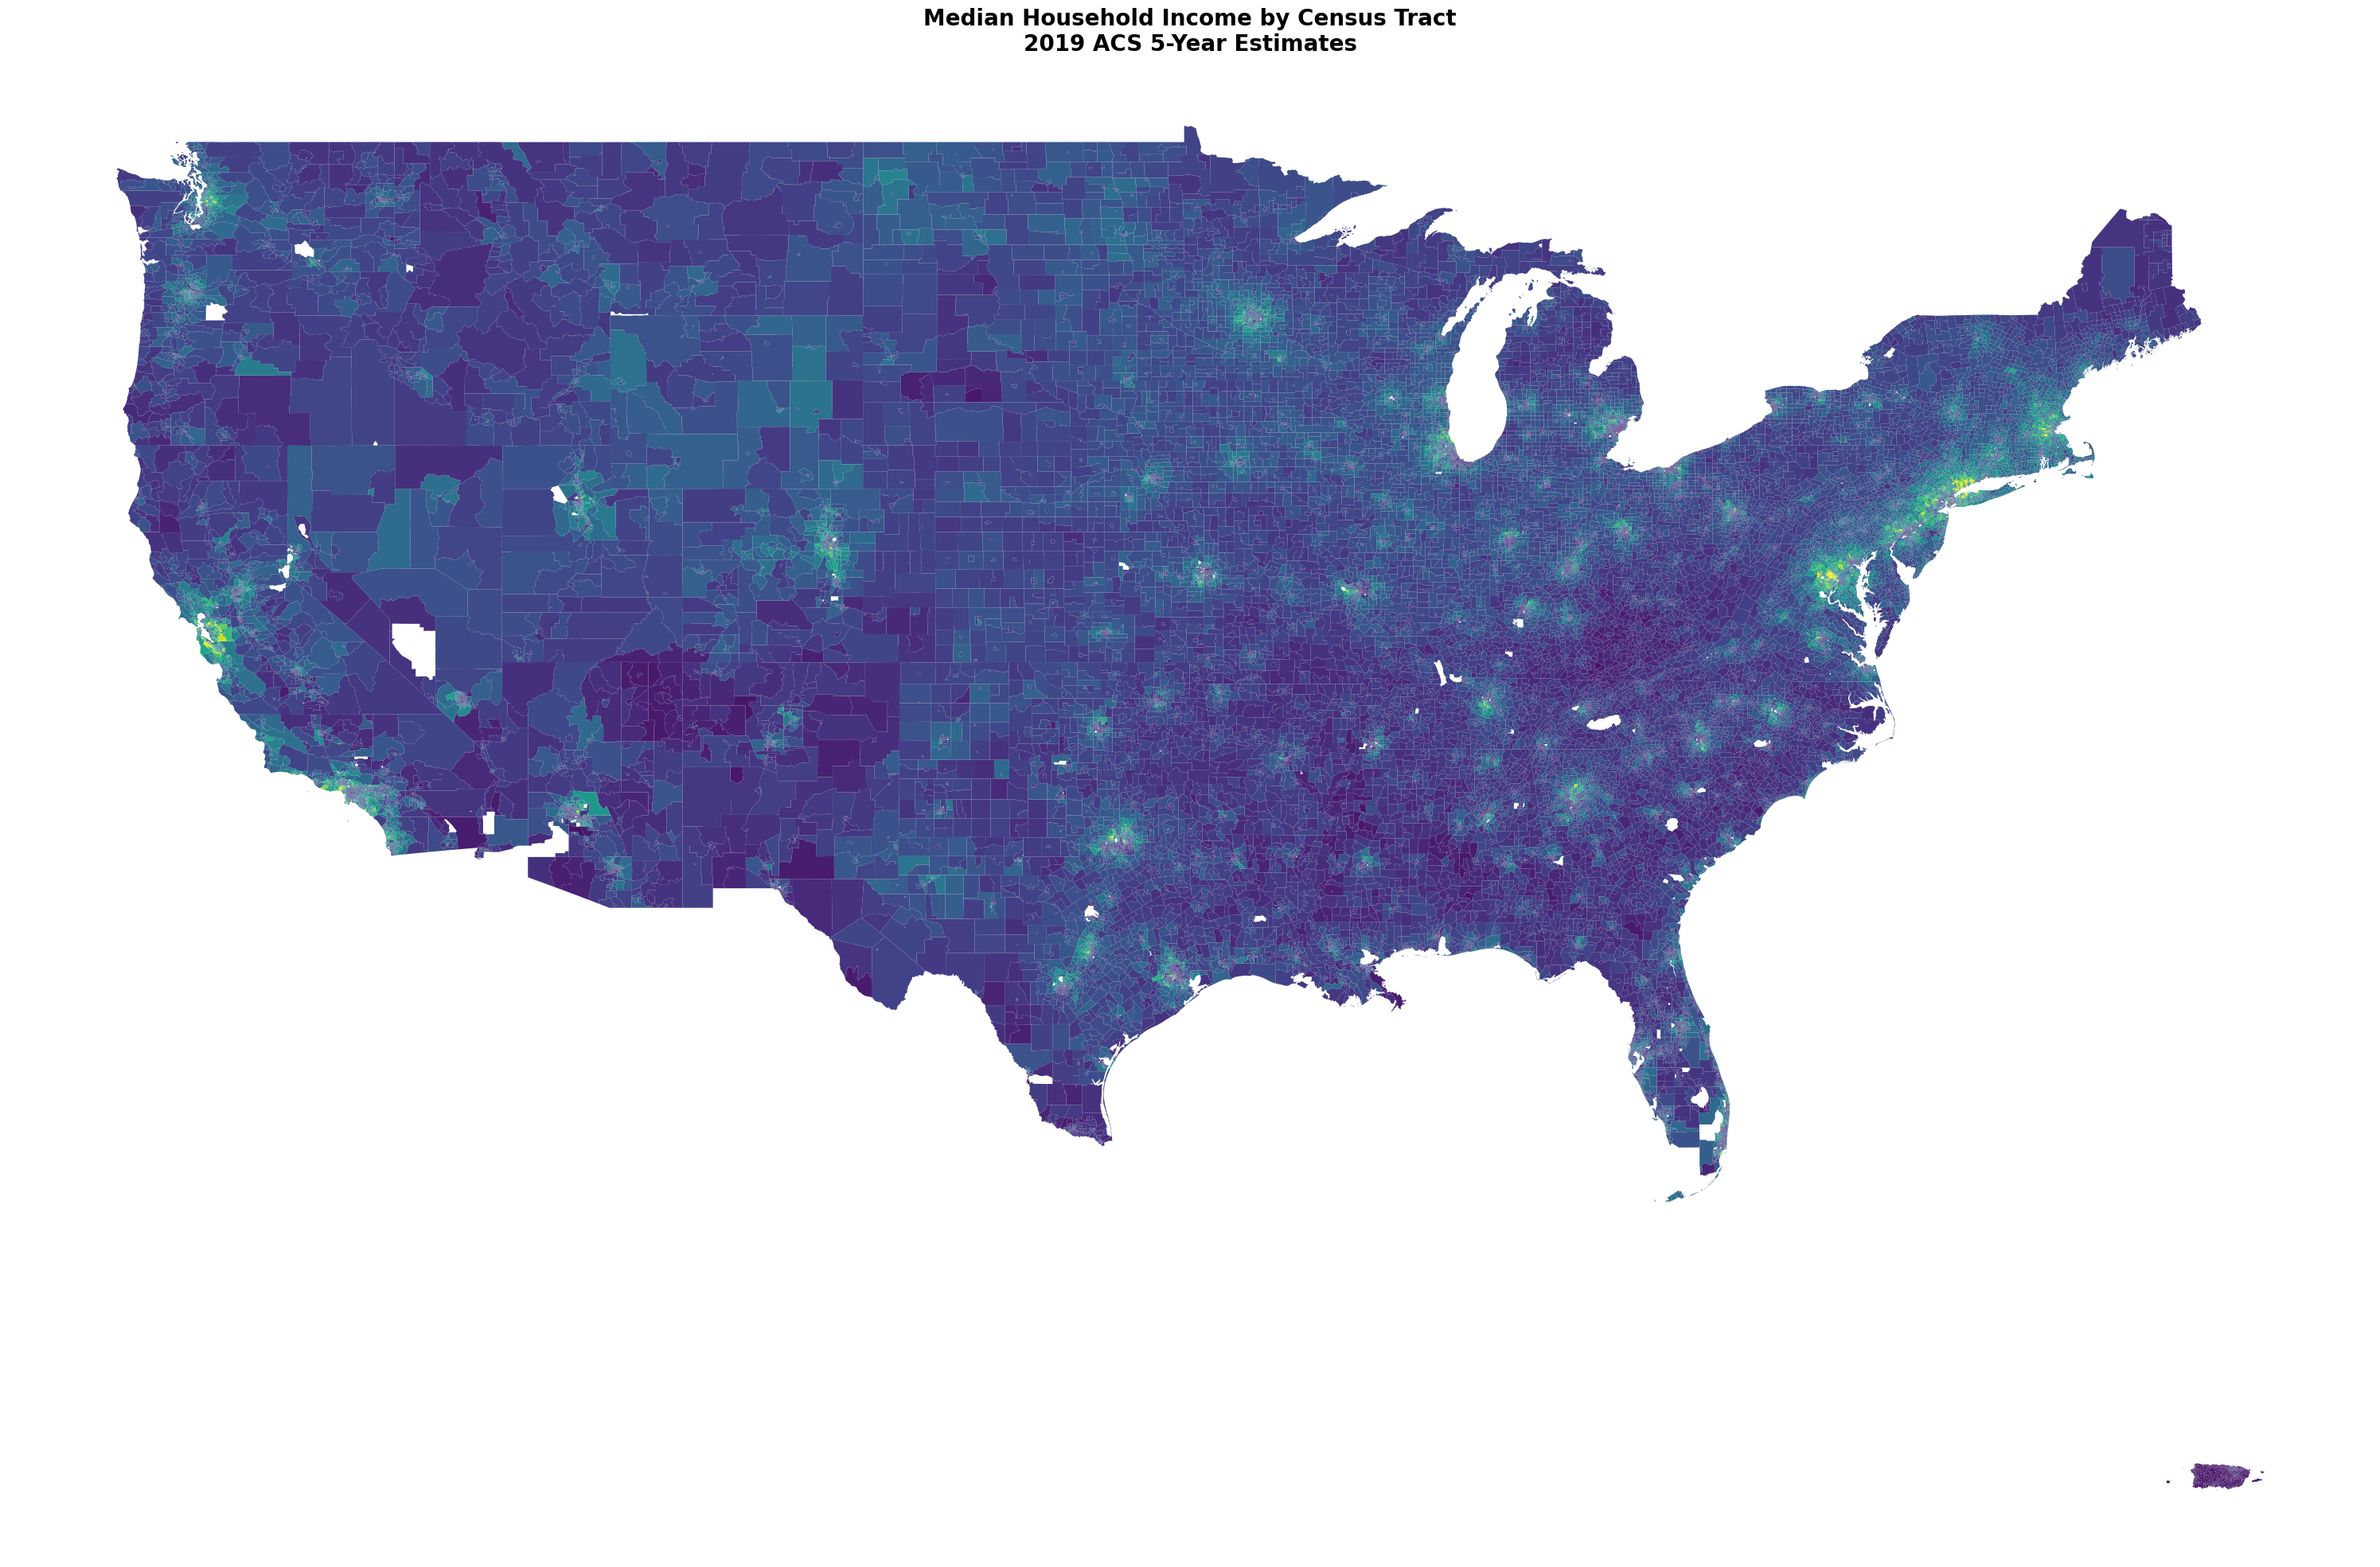

In [7]:
# Create map using GeoPandas plot method
fig, ax = plt.subplots(figsize=(30, 20))

# Use GeoPandas native plot without legend
df.plot(
    column='median_income',
    ax=ax,
    legend=False,
    cmap='viridis',
    missing_kwds={'color': 'lightgrey'}
)

ax.set_title('Median Household Income by Census Tract\n2019 ACS 5-Year Estimates', 
             fontsize=20, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()


<Axes: >

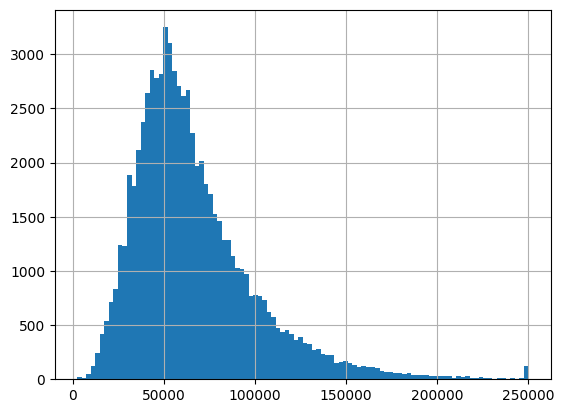

In [8]:
df.median_income.hist(bins=100)

In [9]:
df[df.median_income>0].median_income.describe()

count     72438.000000
mean      66427.692537
std       33650.870281
min        2499.000000
25%       43750.000000
50%       59082.000000
75%       81218.250000
max      250001.000000
Name: median_income, dtype: float64

In [10]:
# Save joined tracts with income to Parquet in data_dir
import os

output_path = os.path.join(data_dir, "tracts_with_income_2019.parquet")
df.to_parquet(output_path)
print(f"Saved {len(df)} rows to {output_path}")

Saved 72438 rows to /Users/max/proj/WirelessIncome/data/tracts_with_income_2019.parquet
